$$ y_{in} = F_{act}((Im+n_{in} W_{in}) + bias) $$
$$ Im^* = F_{act}(y_{in} W_{in}^T) + n_{out} $$

$$ Cost = \sqrt{\langle|Im-Im^*|\rangle} + \lambda \langle r \rangle $$

In [33]:
#Dependencies
import os

import numpy as np
import pylab as pl
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy as scipy
import shutil

import utils.plotutils as plu
import utils.imreadin as imr
#import utils.dirutils as diru

#code to reload
import imp
imp.reload(plu)

#code to limit number of CPUs
maxcpus = 1
#%env CUDA_VISIBLE_DEVICES=0

#image files
ims = 'vh_corr'
#ims = 'vh_uncorr'
#ims = 'vhlognorm'
#ims = 'kyoto'

patch_multiplier = 1

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 200} #plotting pretty

In [2]:
class aec_model(object):
    
    def __init__(self, params):
        params = self.add_params(params)
        self.params = params
        self.make_dirs()
        self.graph = self.make_graph()

    def add_params(self, params):  
        params['compression'] = params['imxlen'] * params['imylen'] / params['nneurons']
        params['savefolder'] = str('./output/image_output/' + 
                                   str(params['ims']) +
                                   '_' + str(vhimgs.shape[0]) +
                                   '_nonlin1_' + str(params['nonlin1'])+ 
                                   '_nonlin2_' + str(params['nonlin2'])+
                                   '_neurons_'+ str(params['nneurons'])+
                                   '_nin_'+ str(params['noise_x'])+
                                   '_nout_'+ str(params['noise_r'])+
                                   '_bsze_'+ str(params['batchsize'])+
                                   '_epochs_'+ str(params['epochs'])+
                                   '_lrate_'+ str(params['learning_rate'])+
                                   '_lambda_act'+ str(params['lambda_act'])+
                                   '_lambda_wgt' + str(params['lambda_wgt'])+
                                   '_fullimzscore_' + str(params['normalize_full_im']) + 
                                   '_invertcolors_' + str(params['colorinvert']) + '/')

        return(params)
        
    def make_dirs(self):
        if os.path.exists(self.params['savefolder']):
            shutil.rmtree(self.params['savefolder'])
        os.makedirs(self.params['savefolder'])
        os.makedirs(self.params['savefolder']+'param_evolution/')
        
    def make_graph(self):
    
        print('Compressing by',self.params['compression'],'for a total of',self.params['nneurons'],'neurons')

        #setup our graph
        #tf.reset_default_graph()
        mygraph = tf.Graph()
        with mygraph.as_default():

            #input images
            with tf.name_scope('input'):
                self.x = tf.placeholder(tf.float32, shape=[self.params["batchsize"], 
                                                           self.params["imxlen"]*self.params["imylen"]])

            #activation function type
            with tf.name_scope('nonliearities'):
                self.nonlin1 = self.params['nonlin1']
                self.nonlin2  = self.params['nonlin2']

            #noises
            with tf.name_scope('noises'):
                self.noisexsigma = self.params['noise_x']
                self.noisersigma = self.params['noise_r']

            #function to add noise
            with tf.name_scope("add_noise"):
                def add_noise(input_layer, std):
                    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
                    return tf.add(input_layer,noise)
            
            #control activation with gamma
            #self.gamma = tf.Variable(tf.ones(self.params['nneurons'], dtype=tf.float32), trainable=False)
            #self.alpha = tf.constant(self.params['alpha'])
                              
            #weights
            with tf.variable_scope("weights"):

                #per Salimans et al 2016 - Weight Normalization: A Simple Reparameterization to Accelerate Training of Deep Neural Networks parameterize weights as w = g/||v||*v. Now ||w|| = g and we can set g to 1 to enfoce this constraint, and learn the direction of the weights v, while maintaining magnitude of norm 1.

                weights_kernel_in = tf.random_normal([self.params['imxlen']*self.params['imylen'],
                                                      self.params['nneurons']],
                                                     dtype=tf.float32,stddev=0.1)
                
                weights_kernel_out = tf.random_normal([self.params['nneurons'],
                                                   self.params['imxlen']*self.params['imylen']],
                                                   dtype=tf.float32,stddev=0.1)
                
                self.win = tf.get_variable('win',initializer=weights_kernel_in)
                

                self.wout = tf.get_variable('wout',initializer=weights_kernel_out)
                

            #bias
            with tf.variable_scope("in_bias"):
                offset = 0 #to keep values positive
                self.inbias = tf.Variable(tf.random_normal([self.params['nneurons']],
                                                         dtype=tf.float32,
                                                         stddev=0.1)+offset)
            with tf.variable_scope("out_bias"):
                offset = 0
                if(params['nonlin2']in['sigmoid','relu','tanh']):
                    self.outbias = tf.Variable(tf.random_normal([self.params['imxlen']*self.params['imylen']],
                                                                dtype=tf.float32,
                                                                stddev=0.1)+offset)
                else:
                    self.outbias = tf.zeros([self.params['imxlen']*self.params['imylen']])
            #lambda
            with tf.name_scope('lambda_activation'):
                self.lambda_act = self.params['lambda_act']
                
            #lambda2
            with tf.name_scope('lambda_weights'):
                self.lambda_wgt = self.params['lambda_wgt']

            #learning_rate
            with tf.name_scope('learning_rate'):
                self.learning_rate = self.params['learning_rate']

            #nonlienarities
            with tf.name_scope("nonlienarities"):
                #define nonlinearities
                def tanh_fun(bias,arg):
                    return tf.nn.tanh(tf.add(arg,bias)) 
                def sigmoid_fun(bias,arg):
                    return tf.nn.sigmoid(tf.add(arg,bias)) 
                def relu_fun(bias,arg):
                    return tf.nn.relu(tf.add(arg,bias)) 
                def no_fun(bias,arg):
                    return arg

            #encoding part of model
            with tf.name_scope("encoding"):
                linearin = tf.matmul(add_noise(self.x,self.params['noise_x']),self.win) #add noise to input, and multiply by weights
                self.yin = tf.case({tf.equal(self.nonlin1,'tanh'): (lambda: tanh_fun(self.inbias,linearin)),
                               tf.equal(self.nonlin1,'sigmoid'): (lambda: sigmoid_fun(self.inbias,linearin)),
                               tf.equal(self.nonlin1,'relu'): (lambda: relu_fun(self.inbias,linearin))},
                               default=(lambda: no_fun(self.inbias,linearin)),
                               exclusive=True)
                self.yin_noised = add_noise(self.yin,self.params['noise_r'])


            #output part of model
            with tf.name_scope("decoding"):
                #calculate output (reconstruction)
                linearout = tf.matmul(self.yin_noised,self.wout) #add noise to inner layer, and multiply by weight  transpose
                self.xp = tf.case({tf.equal(self.nonlin2,'tanh'): (lambda: tanh_fun(self.outbias,linearout)),
                                   tf.equal(self.nonlin2,'sigmoid'): (lambda: sigmoid_fun(self.outbias,linearout)),
                                   tf.equal(self.nonlin2,'relu'): (lambda: relu_fun(self.outbias,linearout))},
                                   default=(lambda: no_fun(self.outbias,linearout)),
                                   exclusive=True, name='output_nonlienarity')
            
            #how well are we reconstructing?
            with tf.name_scope("reconstruction"):
                self.normalize_recon = False
                if self.normalize_recon == True:
                    normx = self.x - tf.reduce_min(self.x,axis=0)
                    normxp = self.xp - tf.reduce_min(self.xp, axis=0)
                else:
                    normx = self.x
                    normxp = self.xp
                #caclculate redonstruction error.
                self.recon_err = tf.norm(normx-normxp,ord=2)
            
            #calculate cost
            with tf.name_scope("cost_function"):
                self.activation = tf.reduce_mean(self.yin,axis=0)
                self.cost = (tf.reduce_mean(self.recon_err) +
                             self.lambda_act * tf.norm(self.activation,ord=1) + 
                             self.lambda_wgt * tf.norm(self.wout, ord=1))

            #update lambda
            #with tf.name_scope('lambda_update'):
            #    self.lambd = self.lambd * (activation/self.params["batchsize"])
                                     
            #train our model
            with tf.name_scope("training_step"):
                self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost)
                #self.train_step = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.cost)
                
            # create a summary for our cost, im, reconstruction, & weights
            with tf.name_scope('cost_viz'):
                tf.summary.scalar("cost", self.cost)

            with tf.name_scope('image_viz'):    
                x_t = tf.reshape(self.x,(self.params['batchsize'],self.params['imxlen'],self.params['imylen'],1))
                tf.summary.image("image", x_t, max_outputs=self.params["batchsize"])

            with tf.name_scope('recon_viz'):
                xp_t = tf.reshape(self.xp,(self.params['batchsize'],self.params['imxlen'],self.params['imylen'],1))
                tf.summary.image("recon", xp_t,max_outputs=self.params["batchsize"])

            with tf.name_scope('inweights_viz'):    
                inwin_t = tf.reshape(tf.transpose(self.win),
                                   (self.params['nneurons'],
                                    self.params['imxlen'],
                                    self.params['imylen'],1))
                tf.summary.image("inweights", inwin_t, max_outputs=self.params['nneurons'])
                
            with tf.name_scope('outweights_viz'):    
                outwin_t = tf.reshape(self.wout,
                                   (self.params['nneurons'],
                                    self.params['imxlen'],
                                    self.params['imylen'],1))
                tf.summary.image("outweights", outwin_t, max_outputs=self.params['nneurons'])

            # merge all summaries into a single "operation" which we can execute in a session 
            self.summary_op = tf.summary.merge_all()

        return(mygraph)


In [3]:
#make session and train model
def train_model(aec):
    with tf.device("/gpu:0"):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True #don't allocate the entire GPU's memory
        config.log_device_placement=True #tell me where devices are placed
        with tf.Session(graph = aec.graph, config=config) as sess:

            #initialize vars
            init = tf.global_variables_initializer()
            sess.run(init)

            #summary writer for tensorboard
            writer = tf.summary.FileWriter(aec.params['savefolder'],
                                           graph=tf.get_default_graph())

            #save evolution of system over training
            cost_evolution = []
            wmean_evolution = []

            inweights_evolution = []
            outweights_evolution = []
            inbias_evolution = []
            activation_evolution = []

            activations = []

            images = []
            recons = []
            print('neurons={}, noise_in={}, noise_out={}, lambda_w={}, lambda_act={}'
                  .format(aec.params['nneurons'],
                          aec.params['noise_x'],
                          aec.params['noise_r'],
                          aec.params['lambda_wgt'],
                          aec.params['lambda_act']))

            print('Training {} iterations in {} epochs... '.format(aec.params['iterations'],
                                                                   aec.params['epochs']))
            for epoch in range(aec.params['epochs']):
                #print('Epoch {}: '.format(epoch+1))
                np.random.shuffle(vhimgs)
                for ii in range(aec.params['iterations']):

                    #reshape our images for feeding to dict
                    image = np.reshape(vhimgs[ii*aec.params['batchsize']:(1+ii)*aec.params['batchsize'],:,:],
                                       (aec.params['batchsize'],
                                        aec.params['imxlen']*aec.params['imylen'])).astype(np.float32)

                    #setup params to send to dictionary
                    feeddict = {aec.x: image}

                    #run our session
                    sess.run(aec.train_step, feed_dict=feeddict)

                    #save evolution of params
                    objcost, inws, acts = sess.run([aec.recon_err, aec.win, aec.yin], feed_dict=feeddict)  #aec.cost
                    cost_evolution.append(objcost)
                    wmean_evolution.append(np.mean(np.abs(inws)))

                    activations.append(np.mean(acts,axis=0))

                    #save detailed parameters 10 times over the total evolution
                    if(ii%(int((aec.params['iterations']*aec.params['epochs'])/10))==0):
                        print(str(ii)+', ',end="")
                        #dump our params
                        win, wout, img, recon, inbias, activation = sess.run([aec.win, aec.wout, aec.x, aec.xp, aec.inbias, aec.activation], feed_dict=feeddict)
                        #save our weights, image, and reconstruction
                        inweights_evolution.append(win)
                        outweights_evolution.append(wout)
                        inbias_evolution.append(inbias)
                        activation_evolution.append(activation)

                        imshape = [aec.params['batchsize'],
                                   aec.params['imxlen'],
                                   aec.params['imylen']]           
                        images.append(np.reshape(img, imshape))
                        recons.append(np.reshape(recon, imshape))

            #summarize final params
            print('Saving...')
            summary, objcost, inws, outws, acts = sess.run([aec.summary_op, aec.cost, aec.win, aec.wout, aec.yin], feed_dict=feeddict)
            cost_evolution.append(objcost)
            wmean_evolution.append(np.mean(inws))
            final_acts = np.mean(acts,axis=0)
            activations.append(final_acts)
            final_inweights_ordered = inws[:,np.argsort(-final_acts)] #reorder based on activations
            final_outweights_ordered = outws.T[:,np.argsort(-final_acts)] #reorder based on activations
            writer.add_summary(summary,ii)
            writer.close()

            print('Training Finished...')

            return(cost_evolution,
                   activations,
                   wmean_evolution,
                   inweights_evolution,
                   outweights_evolution,
                   images,
                   recons,
                   final_inweights_ordered,
                   final_outweights_ordered,
                   inbias_evolution, 
                   activation_evolution
                   )

In [13]:
#parameters constant for all
imsparm = ims
patchparm = 16
fullimnormparm = False
patchmultiplierparm = 1
colorinvertparm = False

with tf.device('/cpu:0'):
    try:
        vhimgs
    except NameError:
        vhimgs, nimages = imr.load_images(imset = imsparm,
                                          patch_edge_size = patchparm,
                                          normalize_im = fullimnormparm,
                                          patch_multiplier = patchmultiplierparm,
                                          normalize_patch = False,
                                          invert_colors = False,
                                          subset = 500
                                         )
        
        #only make anew dict and change these in params dict if we have reloaded images.
        params = {} #make a new dictionary
        #fill up our new dictionary
        params["ims"] = imsparm
        params['normalize_full_im'] = fullimnormparm
        params["patchsize"] = patchparm
        params['patch_multiplier'] = patchmultiplierparm
        params['colorinvert'] = colorinvertparm


params["nimages"] = nimages
params["imxlen"] = params["patchsize"]
params["imylen"] = params["patchsize"]

#params for sweeping
sweep_neurons = [100]
sweep_nonlin1 = ['relu'] #'sigmoid',
sweep_nonlin2 = ['linear']
sweep_lambda_wgt_act = [[0.05,0]]#,[0,0.1],[0.1,0]] #[0,0],[0.1,0],
bsis = [1000] #[100, 500, 1000] #100, 1000
sweep_batch_its = [[bsz, int((np.int(params['nimages']/bsz)))] for bsz in bsis] 
sweep_epochs = [30]
sweep_learning_rates = [0.01] #, 0.001, 0.005, 0.01, 0.015] 
sweep_noise_xs_rs = [[0,0]]#,[0.2,1],[0.1,0.5]] #,[0.1,0.5],[0.2,1]]#,[0.5,2]] #[[0.,0.], [0.05,0.5], [0.2,1], [0.3,2.5]] #[0.,0.], [0.05,0.5], [0.2,1], [0.3,2.5]

In [14]:
for neurons in sweep_neurons:
    params['nneurons'] = neurons
    for nonlin1 in sweep_nonlin1:
        params['nonlin1'] = nonlin1
        for nonlin2 in sweep_nonlin2:
            params['nonlin2'] = nonlin2
            for lambda_wgt,lambda_act in sweep_lambda_wgt_act:
                params['lambda_wgt'] = lambda_wgt    
                params['lambda_act'] = lambda_act
                for batchsize, iterations in sweep_batch_its:
                    params['batchsize'] = batchsize
                    params['iterations'] = iterations
                    for epos in sweep_epochs:
                        params['epochs'] = epos
                        for lr in sweep_learning_rates:
                            params['learning_rate'] = lr
                            for xs,rs in sweep_noise_xs_rs:
                                params['noise_x'] = xs
                                params['noise_r'] = rs

                                #make our model
                                aec = aec_model(params)
                                #train it'
                                [cost_evolution,
                                 activations,
                                 wmean_evolution,
                                 inweights_evolution,
                                 outweights_evolution,
                                 images,
                                 recons,
                                 final_inweights_ordered,
                                 final_outweights_ordered, 
                                 inbias_evolution, 
                                 activation_evolution] = train_model(aec)

                                #save model
                                print('Saving Plots...')
                                plu.save_plots(aec,
                                               activations,
                                               cost_evolution,
                                               wmean_evolution,
                                               inweights_evolution,
                                               outweights_evolution,
                                               images,
                                               recons,
                                               final_inweights_ordered,
                                               final_outweights_ordered,
                                               inbias_evolution, 
                                               activation_evolution)
                                print('Run Finished!')
print("*** Parameter Sweep Finished! ***")

Compressing by 2.56 for a total of 100 neurons
neurons=100, noise_in=0, noise_out=0, lambda_w=0.05, lambda_act=0
Training 3072 iterations in 30 epochs... 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Saving...
Training Finished...
Saving Plots...
Run Finished!
*** Parameter Sweep Finished! ***


(<matplotlib.figure.Figure at 0x7f07448ad630>,
 <matplotlib.image.AxesImage at 0x7f074473acf8>)

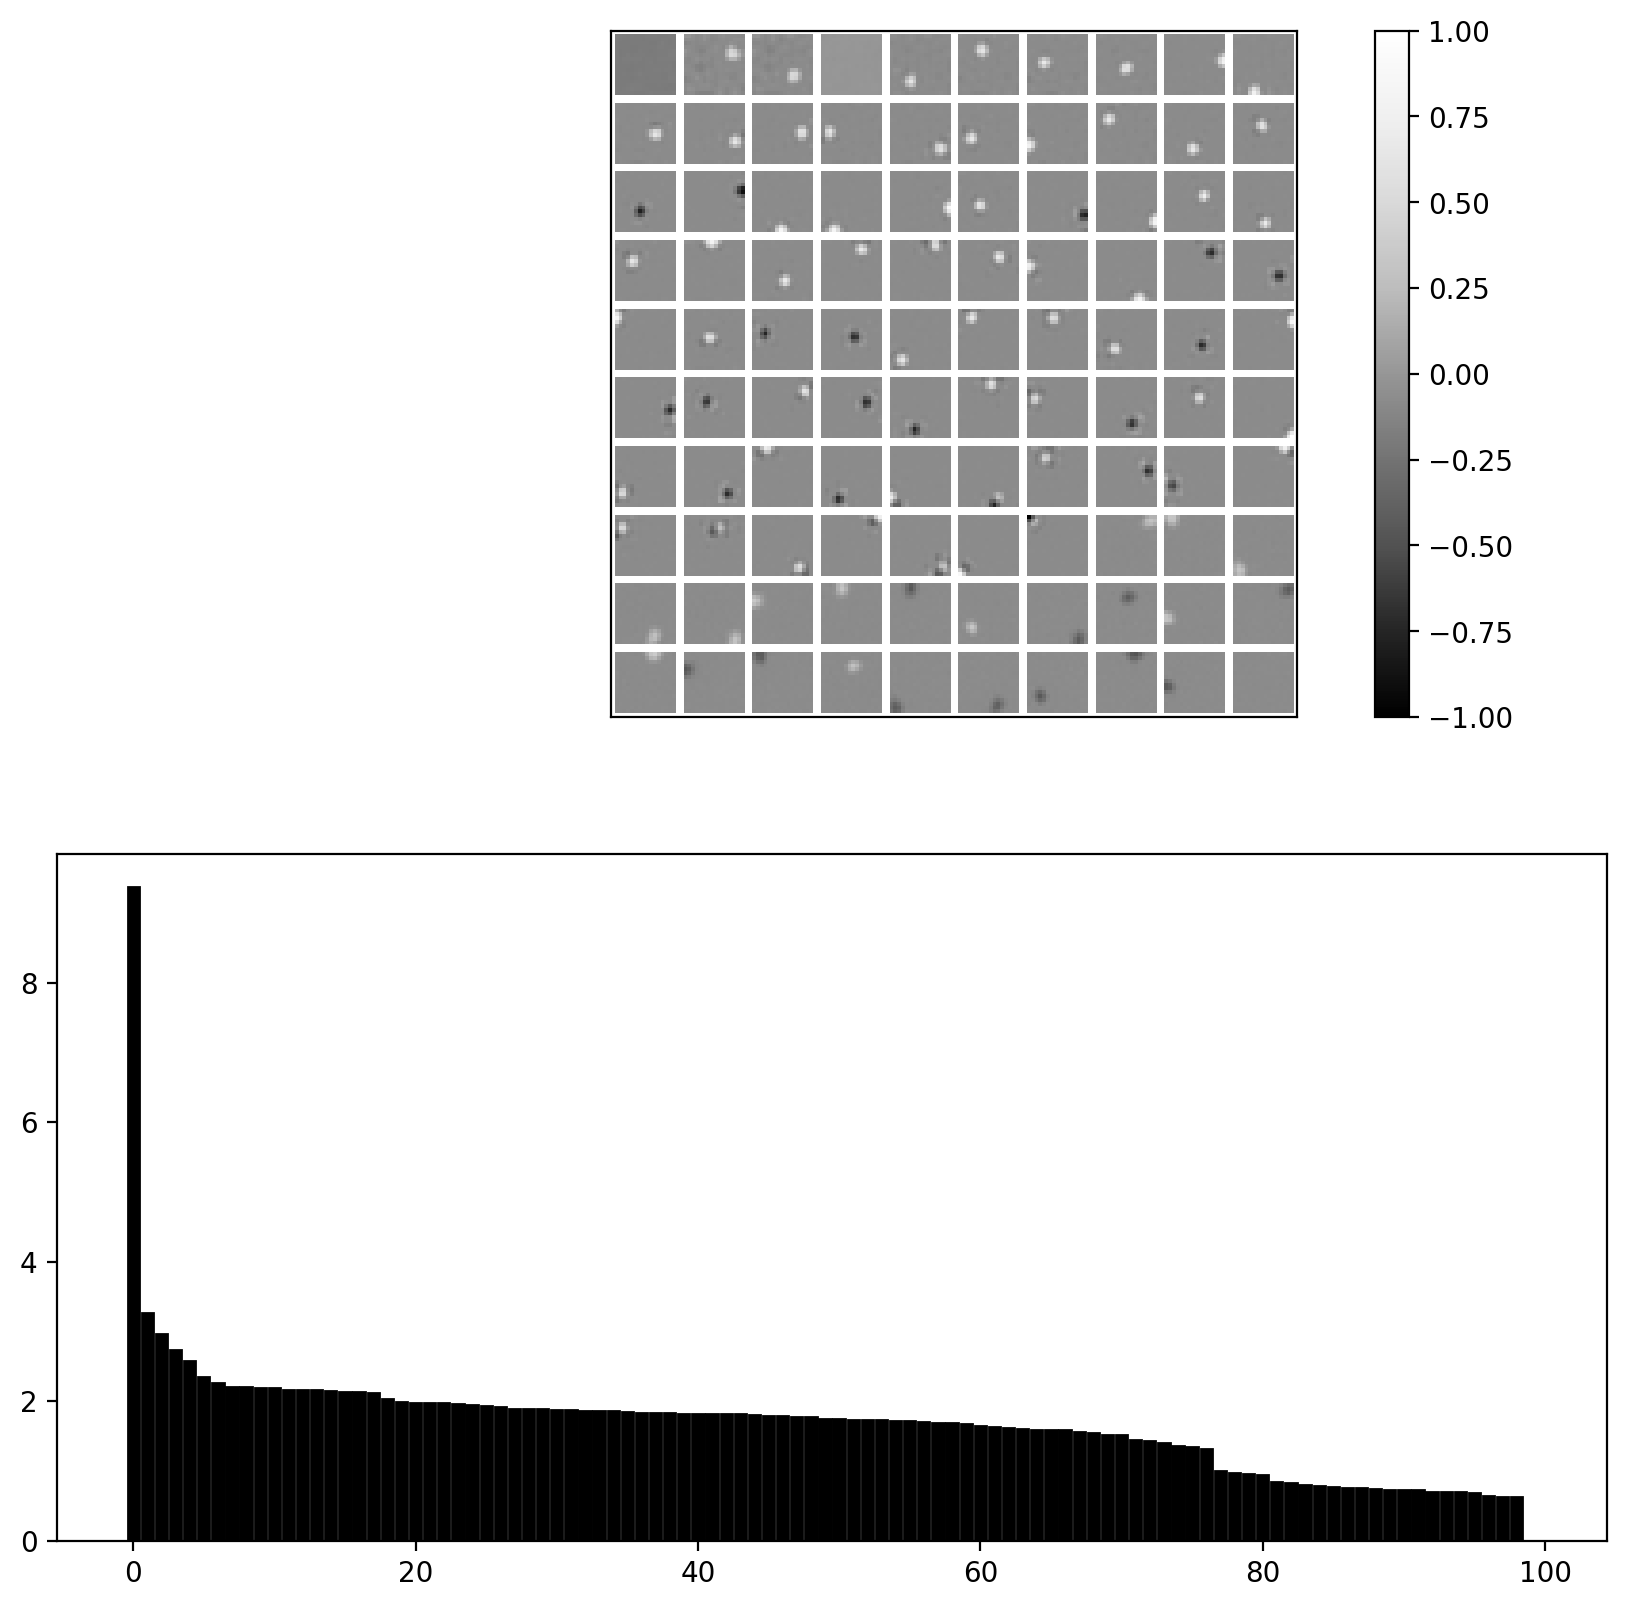

In [24]:
fw = final_outweights_ordered.reshape(aec.params['imxlen'],
                                  aec.params['imylen'],
                                  aec.params['nneurons']).T
final_acts = activations[-1]
plu.display_data_tiled(fw,final_acts[np.argsort(-final_acts)])

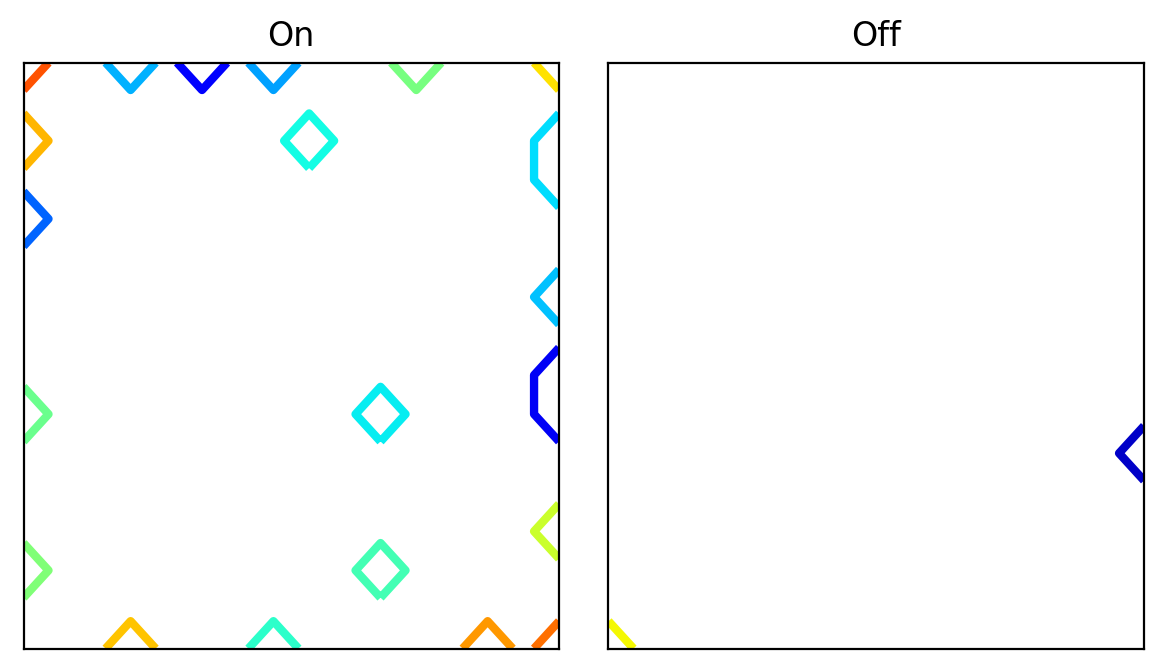

In [25]:
onoff = plu.plotonoff(fw)

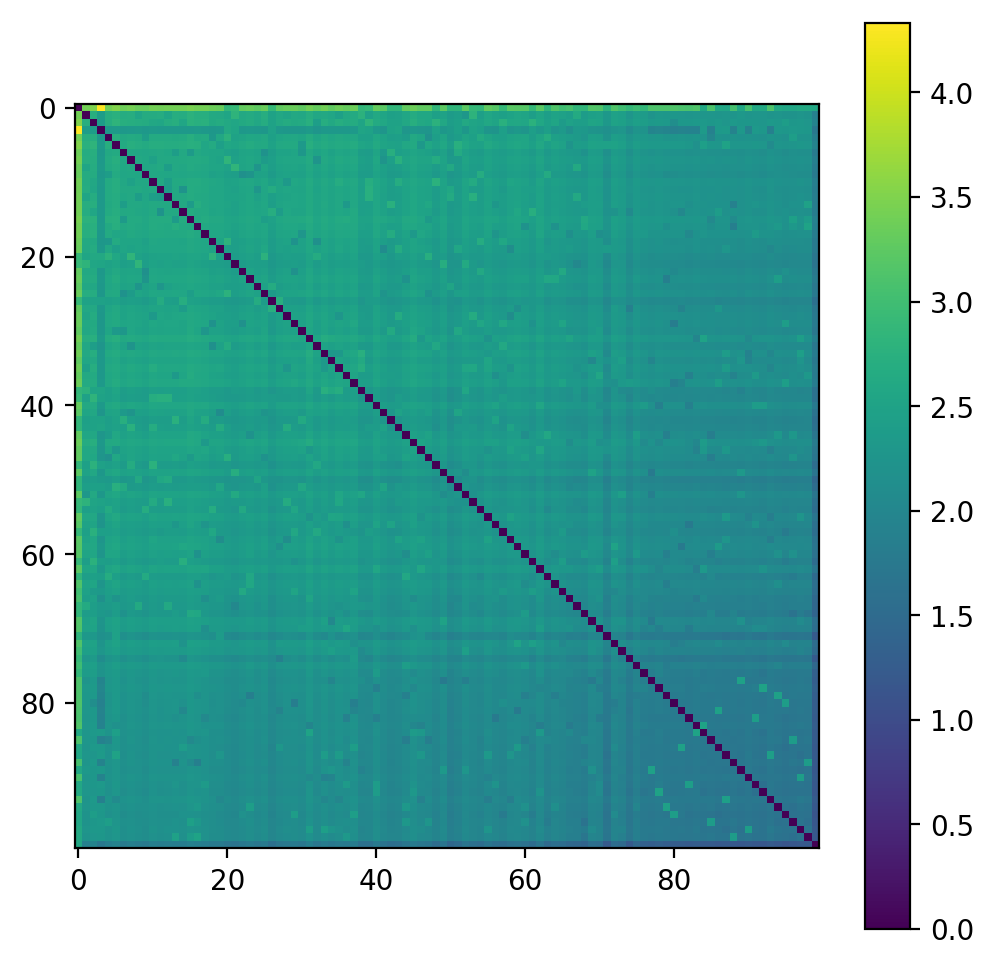

In [26]:
distmat, plot = plu.measure_plot_dist(fw, norm='euclidean')

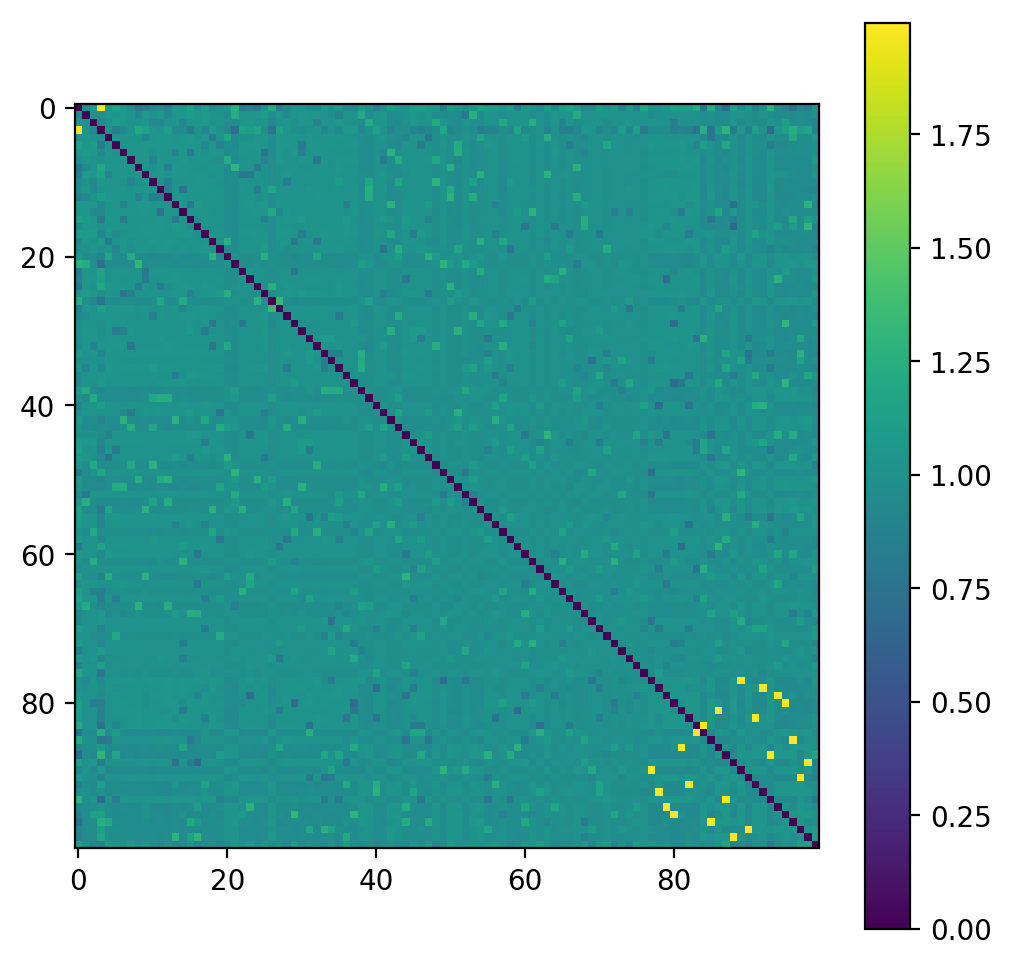

In [27]:
distmat, plot = plu.measure_plot_dist(fw, norm='correlation', normalize = True)

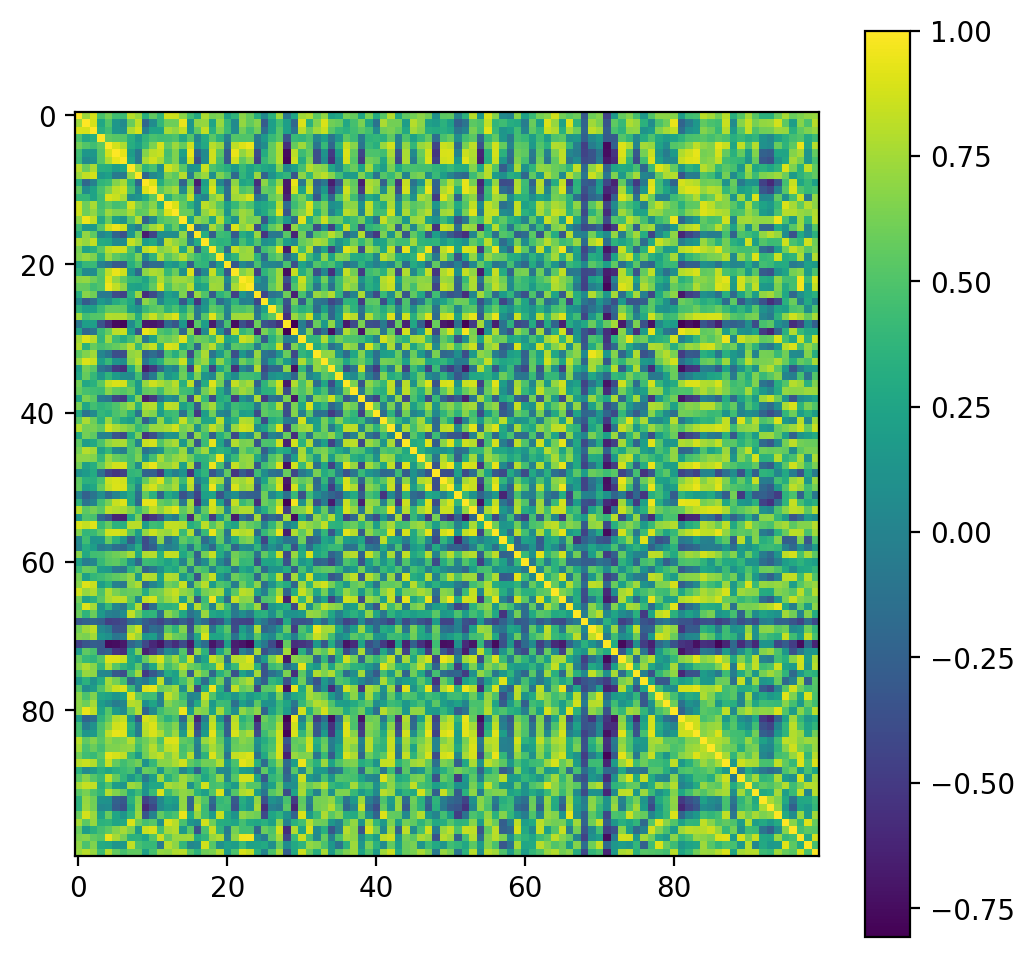

In [28]:
ccfs, plot = plu.measure_plot_act_corrs(activations)

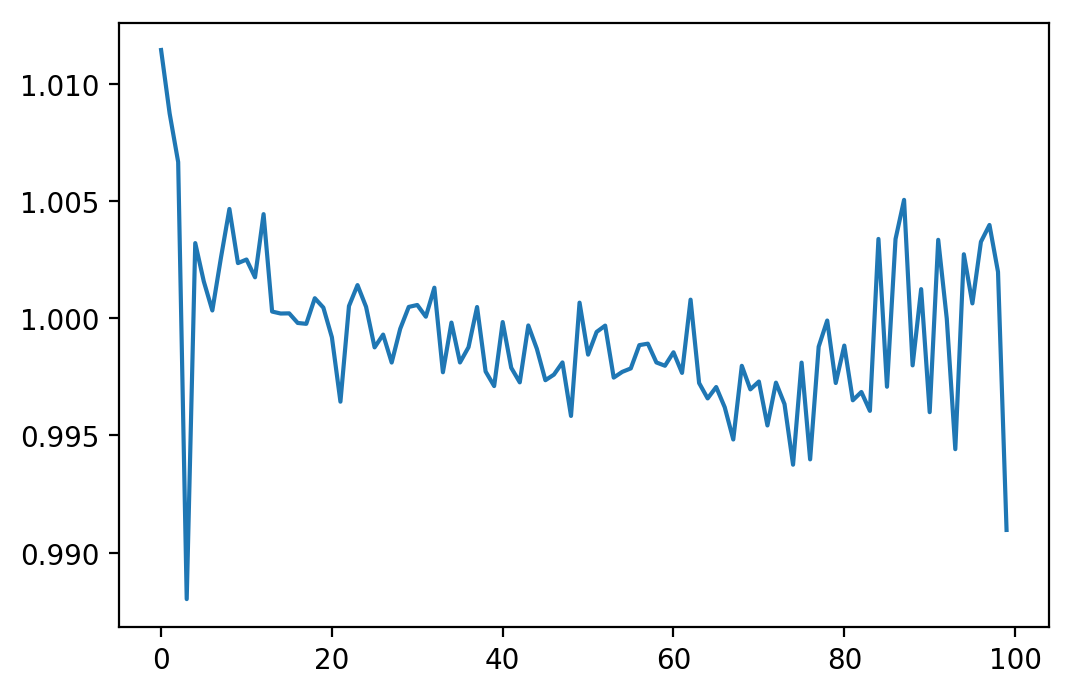

In [29]:
#take average mean for each node
avgm = np.mean(distmat,axis=0) 
plt.plot(avgm)

/home/vasha/anaconda3/lib/python3.5/site-packages/sklearn/manifold/mds.py:396: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


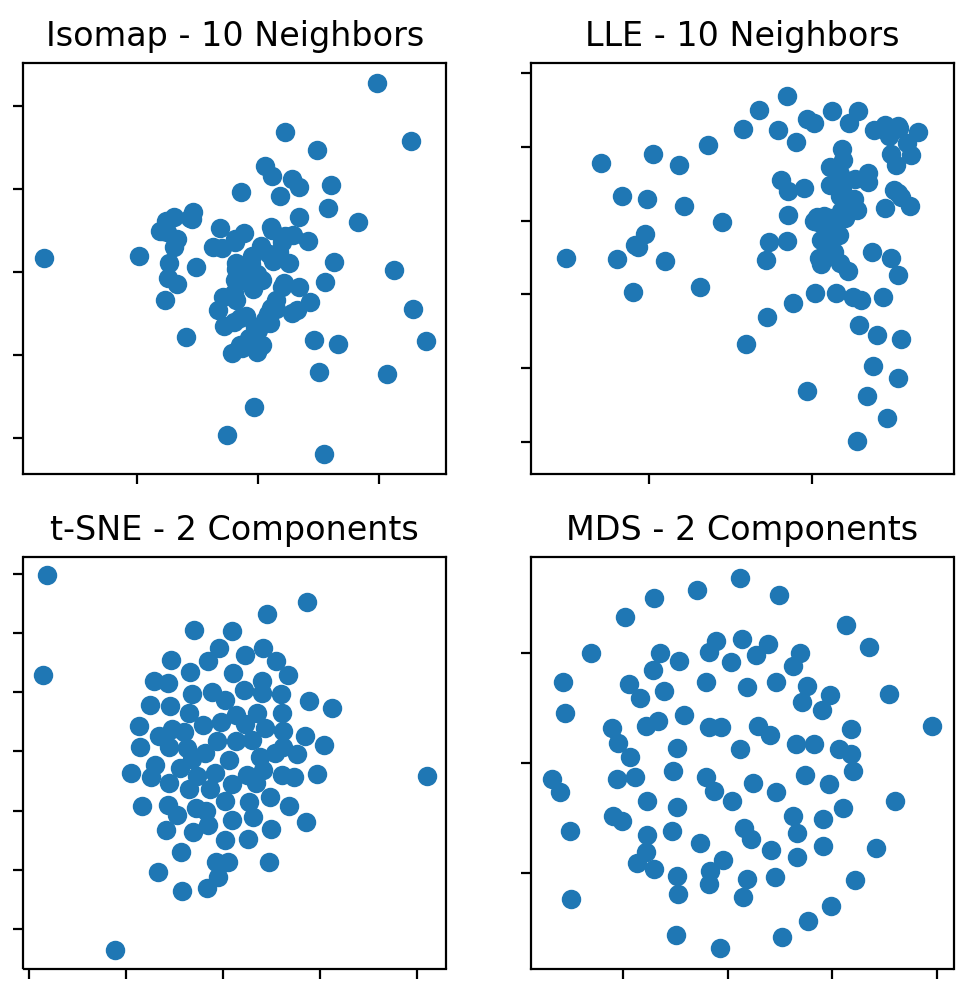

In [34]:
plot = plu.plot_dist_embeddings(distmat)